In [11]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo

# 1. 加载数据
bank_marketing = fetch_ucirepo(id=222)
X = bank_marketing.data.features.copy()
y = bank_marketing.data.targets['y']

# 2. 缺失处理（这里用字符串 'unknown' 统一处理）
X['job'] = X['job'].fillna('unknown')
X['education'] = X['education'].fillna('unknown')
X['contact'] = X['contact'].fillna('unknown')
X = X.drop(columns=['poutcome'])  # 删除缺失太多的字段


In [12]:
# 3. 对严重右偏的字段进行对数变换
skewed_cols = ['balance', 'duration', 'campaign', 'pdays', 'previous']

for col in skewed_cols:
    if (X[col] <= 0).any():
        shift = 1 - X[col].min()
        print(f"{col} 包含非正值，使用 log1p(x + {shift}) 变换")
        X[col] = np.log1p(X[col] + shift)
    else:
        X[col] = np.log1p(X[col])


balance 包含非正值，使用 log1p(x + 8020) 变换
duration 包含非正值，使用 log1p(x + 1) 变换
pdays 包含非正值，使用 log1p(x + 2) 变换
previous 包含非正值，使用 log1p(x + 1) 变换


In [13]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# 再次确认变量类型
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# 构建 ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ]
)

# 应用预处理
X_processed = preprocessor.fit_transform(X)

# 获取列名
feature_names = numerical_cols + list(
    preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
)

# 转为 DataFrame
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

# 查看处理后的结果（选做）
X_processed_df.head()


,age,balance,day_of_week,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,1.606965,0.507849,-1.298476,0.429397,-0.909457,-0.466296,-0.405898,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.288529,-0.590387,-1.298476,-0.165459,-0.909457,-0.466296,-0.405898,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.747384,-0.606210,-1.298476,-0.905277,-0.909457,-0.466296,-0.405898,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.571051,0.203019,-1.298476,-0.700388,-0.909457,-0.466296,-0.405898,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.747384,-0.606797,-1.298476,0.128698,-0.909457,-0.466296,-0.405898,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [14]:
X_processed_df.to_csv('processed_bank_data.csv', index=False)
X.to_csv('raw_bank_data.csv', index=False)


前2个主成分总共解释了 31.29% 的方差
每个主成分贡献： [0.18983158 0.12310594]


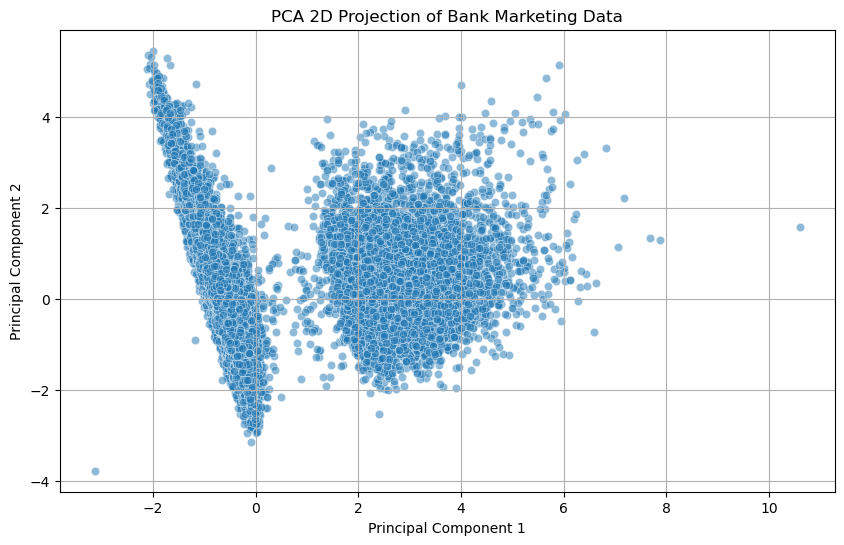

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 实例化 PCA，保留前两个主成分
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_processed_df)

# 2. 主成分方差解释
explained_var = pca_2d.explained_variance_ratio_
print(f"前2个主成分总共解释了 {explained_var.sum():.2%} 的方差")
print(f"每个主成分贡献： {explained_var}")

# 3. 绘图（PCA二维投影）
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca_2d[:, 0], y=X_pca_2d[:, 1], alpha=0.5)
plt.title("PCA 2D Projection of Bank Marketing Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


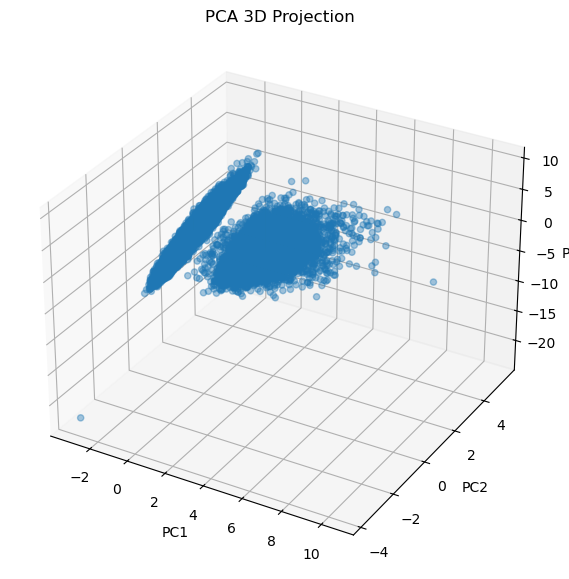

In [16]:
from mpl_toolkits.mplot3d import Axes3D

# 3D PCA
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_processed_df)

# 3D 绘图
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], alpha=0.4)
ax.set_title("PCA 3D Projection")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()


直接运用pca效果不好
你观察得非常准确：
🔍 PCA 仅解释了 31.79% 的方差，说明数据维度仍然很“分散”，降维效果不理想——这是因为你的数据集中：

大量分类变量独热编码后维度爆炸（如 job、education、month 等）
部分变量对聚类没有贡献，甚至引入噪声
变量之间缺乏足够的线性结构（PCA 是线性方法）


In [17]:
pca_full = PCA(n_components=0.9)
X_pca_full = pca_full.fit_transform(X_processed_df)
print(f"原始特征维度：{X_processed_df.shape[1]}, 降维后：{X_pca_full.shape[1]}")


原始特征维度：39, 降维后：15


In [18]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
X_var_filtered = selector.fit_transform(X_processed_df)
print(f"剔除低方差后维度：{X_var_filtered.shape[1]}")


剔除低方差后维度：37


✅ 第三种方式：SelectKBest + 无监督变体
虽然 SelectKBest 多用于监督学习，也可以借用其机制评估每列与潜在结构的关系：

In [ ]:
这一步并不是严格的无监督方法，但可以帮你先过滤掉显著无关的特征。

In [8]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# 使用互信息估计每个特征对 y 的“预测力”
selector = SelectKBest(mutual_info_classif, k=20)
X_selected = selector.fit_transform(X_processed_df, y.map({'yes': 1, 'no': 0}))  # 转换为 0/1 标签

selected_indices = selector.get_support(indices=True)
selected_features = X_processed_df.columns[selected_indices].tolist()

print("选出的变量：", selected_features)


选出的变量： ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'job_blue-collar', 'job_services', 'marital_married', 'marital_single', 'education_secondary', 'housing_yes', 'contact_unknown', 'month_aug', 'month_jul', 'month_mar', 'month_may', 'month_oct', 'month_sep']


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


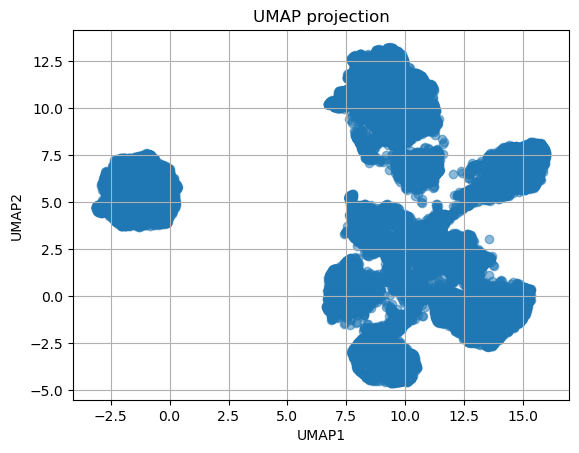

In [10]:
import umap

reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_processed_df)

import matplotlib.pyplot as plt
plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.5)
plt.title('UMAP projection')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.grid(True)
plt.show()


In [20]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif

def feature_selection(X_df, y=None, method='variance', threshold=0.01, k=20):
    """
    筛选特征的方法：
    - method: 'variance' or 'mutual_info'
    - threshold: 对于 variance 筛选的最小方差阈值
    - k: 对于互信息筛选的保留特征数量
    """
    print(f"原始特征数量：{X_df.shape[1]}")

    if method == 'variance':
        selector = VarianceThreshold(threshold=threshold)
        X_selected = selector.fit_transform(X_df)
        selected_features = X_df.columns[selector.get_support()].tolist()

    elif method == 'mutual_info':
        # 需要将 y 转换为二进制
        y_binary = y.map({'yes': 1, 'no': 0})
        selector = SelectKBest(mutual_info_classif, k=min(k, X_df.shape[1]))
        X_selected = selector.fit_transform(X_df, y_binary)
        selected_features = X_df.columns[selector.get_support()].tolist()

    else:
        raise ValueError("method must be 'variance' or 'mutual_info'")
    
    print(f"筛选后特征数量：{len(selected_features)}")
    print("保留的特征名如下：")
    print(selected_features)

    return X_selected, selected_features


In [21]:
# 1. Variance 筛选（无监督）
X_selected_var, features_var = feature_selection(X_processed_df, method='variance', threshold=0.01)

# 2. Mutual Info 筛选（监督）
X_selected_mi, features_mi = feature_selection(X_processed_df, y=y, method='mutual_info', k=30)


原始特征数量：39
筛选后特征数量：37
保留的特征名如下：
['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_married', 'marital_single', 'education_secondary', 'education_tertiary', 'education_unknown', 'default_yes', 'housing_yes', 'loan_yes', 'contact_telephone', 'contact_unknown', 'month_aug', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep']
原始特征数量：39
筛选后特征数量：30
保留的特征名如下：
['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'job_blue-collar', 'job_retired', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_married', 'marital_single', 'education_secondary', 'education_tertiary', 'housing_yes', 'loan_yes', 'contact_telephone', 'contact_unknown', 'month_dec', 'month_feb', 'month_jul',